In [1]:
!pip install --quiet gymnasium matplotlib numpy

In [2]:
!pip install --quiet optuna

In [3]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import optuna

# ENVIRONMENT SETUP

In [4]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, max_timesteps=10):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.battery1_pos = [0, 3]
        self.battery2_pos = [2, 3]
        self.rock1_pos = [2, 0]
        self.rock2_pos = [3, 1]

        self.state = np.zeros((4,4))

        self.state[tuple(self.goal_pos)] = 4
        self.state[tuple(self.battery1_pos)] = 6
        self.state[tuple(self.battery2_pos)] = 6
        self.state[tuple(self.rock1_pos)] = 12
        self.state[tuple(self.rock2_pos)] = 12
        self.state[tuple(self.agent_pos)] = 10

        self.total_rewards = 0

        
    def reset(self, **kwargs):

        self.timestep = 0
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.battery1_pos = [0, 3]
        self.battery2_pos = [2, 3]
        self.rock1_pos = [2, 0]
        self.rock2_pos = [3, 1]

        self.state = np.zeros((4,4))

        self.state[tuple(self.goal_pos)] = 4
        self.state[tuple(self.battery1_pos)] = 6
        self.state[tuple(self.battery2_pos)] = 6
        self.state[tuple(self.rock1_pos)] = 12
        self.state[tuple(self.rock2_pos)] = 12
        self.state[tuple(self.agent_pos)] = 10

        observation = self.state.flatten()
        self.total_rewards = 0

        return observation, self.total_rewards
    
    def step(self, action):
        # agent moves down
        if action == 0:
          self.agent_pos[0] += 1

        # agent moves up
        if action == 1:
          self.agent_pos[0] -= 1

        # agent moves right
        if action == 2:
          self.agent_pos[1] += 1

        # agent moves left
        if action == 3:
          self.agent_pos[1] -= 1

        # prevents agent from moving out of board
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4,4))
        self.state[tuple(self.goal_pos)] = 4
        if(self.battery1_pos[0] != 10):
          self.state[tuple(self.battery1_pos)] = 6
        if(self.battery2_pos[0] != 10):
          self.state[tuple(self.battery2_pos)] = 6
        self.state[tuple(self.rock1_pos)] = 12
        self.state[tuple(self.rock2_pos)] = 12
        self.state[tuple(self.agent_pos)] = 10
        observation = self.state.flatten()
        
        reward = 0
        terminated = False
        condition_passed = False
        negative_condition_passed = True

        if np.array_equal(self.agent_pos, self.goal_pos):
          condition_passed = True
          terminated = True
          reward = 10

        if self.battery1_pos[0] != 10 and np.array_equal(self.agent_pos, self.battery1_pos):
          condition_passed = True
          reward = 6
          self.battery1_pos = [10, 10]

        if self.battery2_pos[0] != 10 and np.array_equal(self.agent_pos, self.battery2_pos):
          condition_passed = True
          reward = 6
          self.battery2_pos = [10, 10]
        
        if np.array_equal(self.agent_pos, self.rock1_pos):
          condition_passed = True
          negative_condition_passed = False
          reward = -6

        if np.array_equal(self.agent_pos, self.rock2_pos):
          condition_passed = True
          negative_condition_passed = False
          reward = -6
        
        self.timestep += 1
        self.total_rewards = self.total_rewards + reward

        if(self.timestep >= self.max_timesteps or np.array_equal(self.agent_pos, self.goal_pos)):
          terminated = True
        else: 
          terminated = False
        
        return observation, reward, terminated, negative_condition_passed, self.total_rewards
        
    def render(self, path_given=False):
      if(path_given):
        plt.imsave(path_given, self.state)
        # plt.clf()
      else:
        plt.imshow(self.state)
        # plt.clf()

In [5]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, algo_applied=5):
    if algo_applied == 5:
      return np.random.choice(self.action_space.n)
    else:
      return algo_applied

# PART 3: Q-LEARNING IMPLEMENTATION

In [6]:
def QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, q_table):

  def action_select(epsilon, state):
    # Exploitation
    if(np.random.uniform() > epsilon):
      return np.argmax(q_table[state])

    # Exploration
    else:
      return np.random.randint(4)

  rewards = []
  timesteps = []
  bad_rewards = []
  epsilon_values = []
  epsilon_values.append(epsilon)

  for i in range(0, total_episodes):
    env.reset()
    terminated = False
    agent = RandomAgent(env)

    state_prev = 0
    action_prev = action_select(epsilon, 0)

    state_count = 0
    bad_reward_count = 0
    while(not terminated):
      action = agent.step(action_prev)
      observation, reward, terminated, bad_reward, total_rewards = env.step(action)
      if(not bad_reward):
        bad_reward_count += 1
      state_next = int(np.where(observation == 10)[0])
      action_next = action_select(epsilon, int(np.where(observation == 10)[0]))
      q_table[state_prev][action_prev] = q_table[state_prev][action_prev] + learning_rate * (reward + (discount_factor * np.max(q_table[state_next])) - (q_table[state_prev][action_prev]))
      
      state_prev = state_next
      action_prev = action_next
      state_count += 1
      if(terminated):
        rewards.append(total_rewards)
        timesteps.append(state_count)
        bad_rewards.append(bad_reward_count)

    epsilon = epsilon * decay_rate
    epsilon_values.append(epsilon) 

  return q_table, rewards, timesteps, bad_rewards, epsilon_values

In [7]:
def reward_plot(rewards):
  plt.plot(rewards, 'ro')
  plt.title("Reward per Episode")
  plt.xlabel("Episode")
  plt.ylabel("Reward Value")
  plt.grid()
  return plt

In [8]:
def cumulative_reward_plot(rewards):
  x = list(range(1, len(rewards) + 1))
  y = [0] * len(rewards)
  y[0] = rewards[0]
  for i in range(1, len(rewards)):
    y[i] = y[i - 1] + rewards[i]
  plt.plot(y)
  plt.xlabel('Episode')
  plt.ylabel('Cumulative Rewards')
  plt.title('Cumulative Reward per Episode')
  plt.grid()
  return plt

In [9]:
def epsilon_decay_plot(epsilon_values):
  plt.plot(epsilon_values)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon Values')
  plt.title('Epsilon Decay')
  plt.grid()
  return plt

In [10]:
def timestep_episode_plot(timestep_values):
  x = list(range(1, len(timestep_values) + 1))
  y = timestep_values
  plt.plot(timestep_values)
  plt.xlabel('Episode')
  plt.ylabel('Number of Timesteps')
  plt.title('Timesteps per Episode')
  plt.grid()
  return plt

In [11]:
def negative_rewards_episode_plot(negative_rewards):
  x = list(range(1, len(negative_rewards) + 1))
  y = negative_rewards
  plt.plot(negative_rewards)
  plt.xlabel('Episode')
  plt.ylabel('Number of Negative Rewards')
  plt.title('Negative Rewards per Episode')
  plt.grid()
  return plt

In [12]:
total_episodes = 90
timesteps_per_episode = 88
learning_rate = 0.14747361007322826
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9234112976488047
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

## Training Vizualization

### Plot 1: Epsilon-Decay Plot

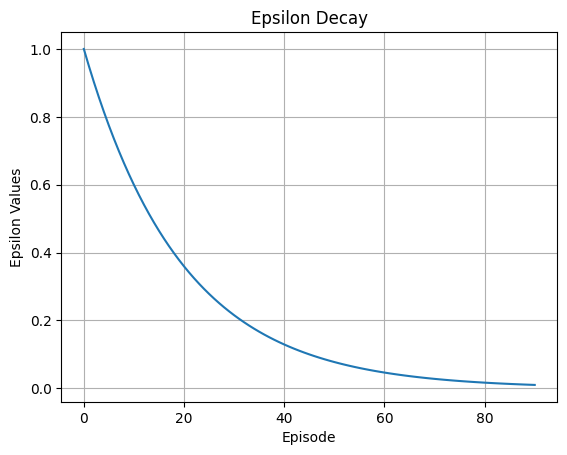

In [13]:
epsilon_decay = epsilon_decay_plot(q_learning_output[4])
epsilon_decay.show()

### Plot 2: Total Reward vs. Episode

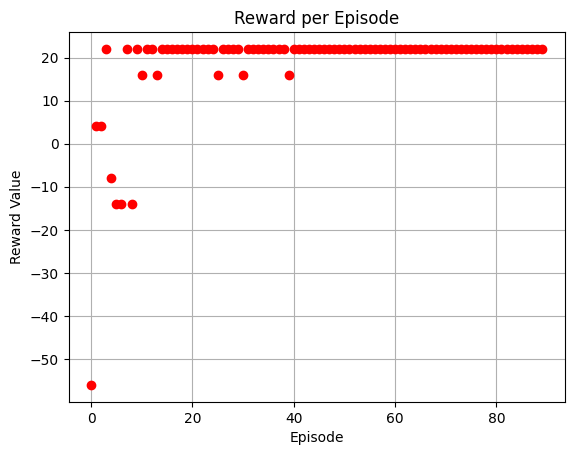

In [14]:
rewards_vs_episode = reward_plot(q_learning_output[1])
rewards_vs_episode.show()

### Plot 3: Cumulative Rewards vs. Episode

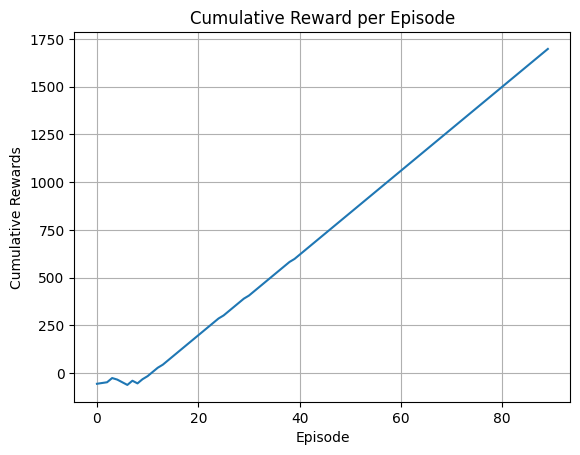

In [15]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output[1])
cumulative_rewards_vs_episode.show()

### Plot 4: Timesteps vs. Episode

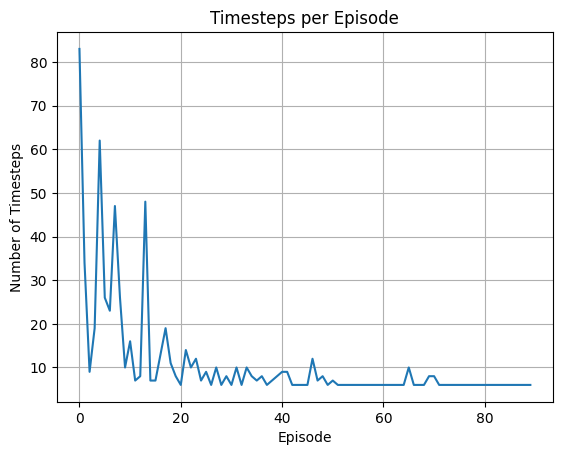

In [16]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output[2])
timesteps_vs_episode.show()

### Plot 5: Negative Rewards vs. Episode

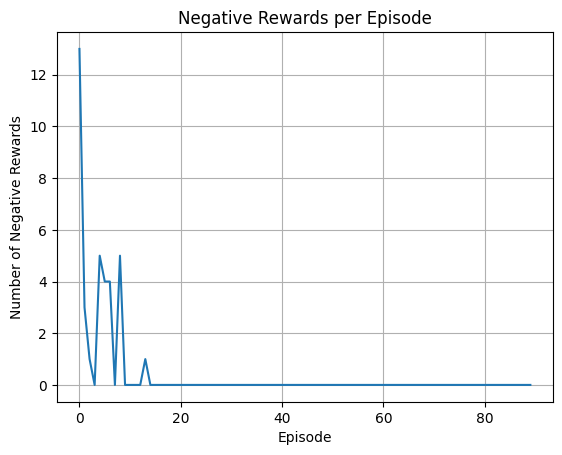

In [17]:
negative_rewards = negative_rewards_episode_plot(q_learning_output[3])
negative_rewards.show()

## Validation

In [18]:
def algo_validator(env, q_table):

  def greedy_select(state):
    return np.argmax(q_table[state])

  rewards = []

  for i in range(10):
    env.reset()
    terminated = False
    agent = RandomAgent(env)
    current_state = 0
    best_action = greedy_select(current_state)
    while(not terminated):
      action = agent.step(best_action)
      observation, reward, terminated, _, total_rewards = env.step(action)
      best_action = greedy_select(int(np.where(observation == 10)[0]))
      if(terminated):
        rewards.append(total_rewards)

  return rewards

In [19]:
env = GridEnvironment(max_timesteps=88)
decay_rate = pow((0.01 / 1), (1 / 90))
Q_table = np.zeros((env.observation_space.n, env.action_space.n))
optimal_q_values = QLearning(env, 105, 0.14747361007322826, 1, 0.9234112976488047, decay_rate, Q_table)[0]
validation_rewards = algo_validator(env, optimal_q_values)

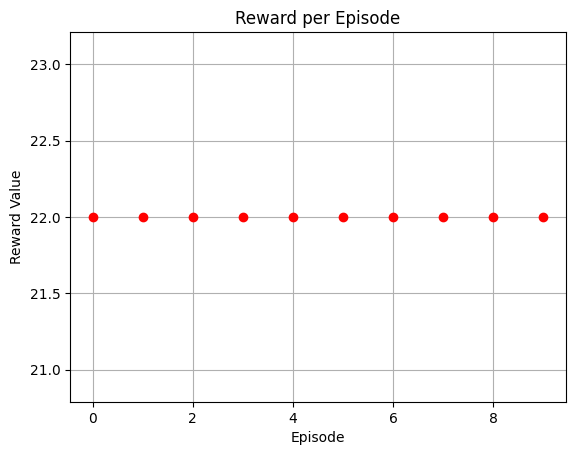

In [20]:
rewards_vs_episode = reward_plot(validation_rewards)
rewards_vs_episode.show()

## Hyper Parameter Tuning

### Parameter 1: Learning Rate

#### Parameter 1, Setup 1: Learning Rate - 0.1

In [21]:
total_episodes = 30
timesteps_per_episode = 30
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_11 = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

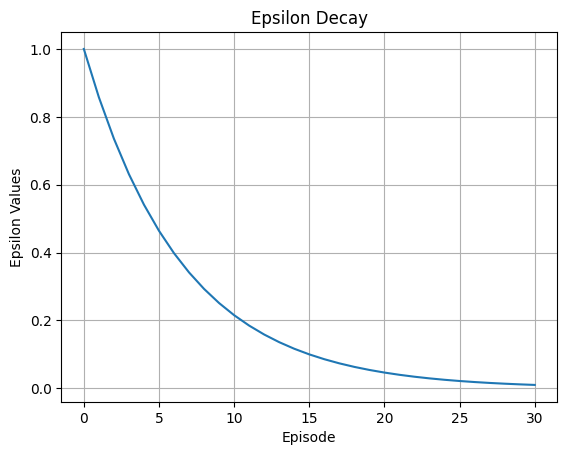

In [22]:
epsilon_decay = epsilon_decay_plot(q_learning_output_11[4])
epsilon_decay.show()

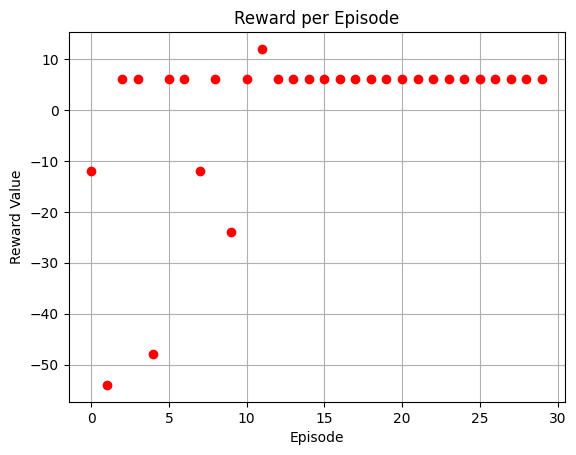

In [23]:
ewards_vs_episode = reward_plot(q_learning_output_11[1])
rewards_vs_episode.show()

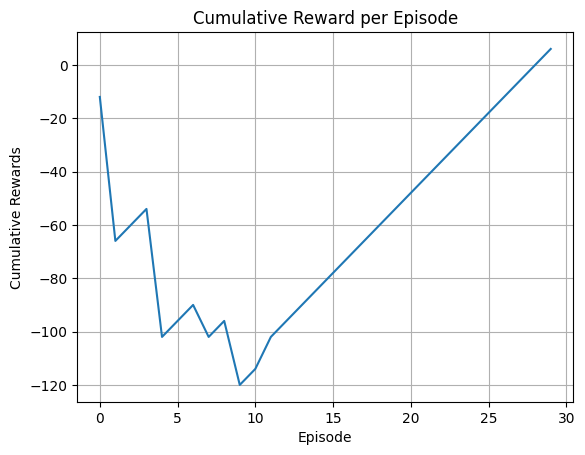

In [24]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output_11[1])
cumulative_rewards_vs_episode.show()

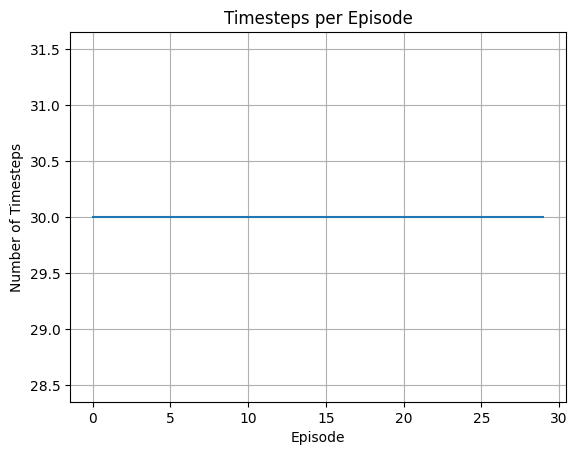

In [25]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output_11[2])
timesteps_vs_episode.show()

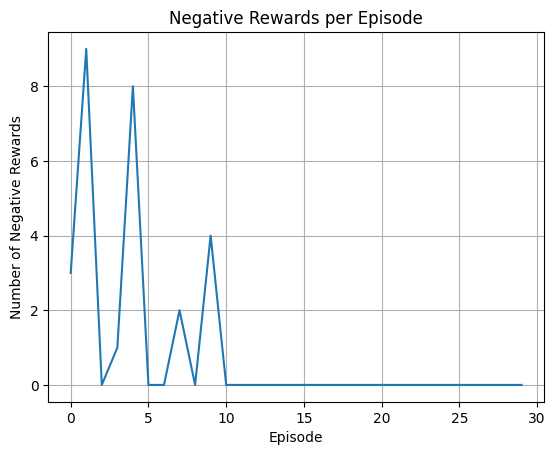

In [26]:
negative_rewards = negative_rewards_episode_plot(q_learning_output_11[3])
negative_rewards.show()

#### Parameter 1, Setup 2: Learning Rate - 0.2

In [27]:
total_episodes = 30
timesteps_per_episode = 30
learning_rate = 0.2
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_12 = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

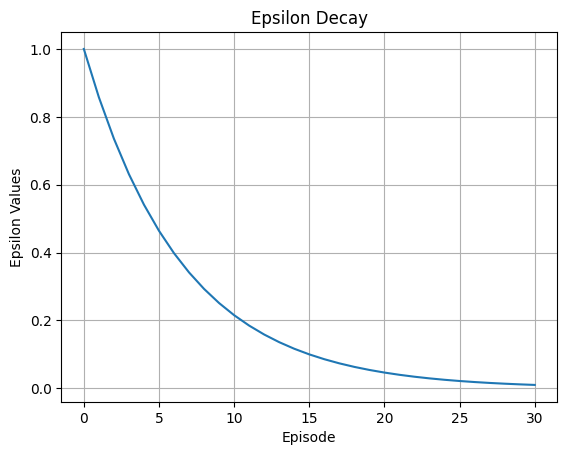

In [28]:
epsilon_decay = epsilon_decay_plot(q_learning_output_12[4])
epsilon_decay.show()

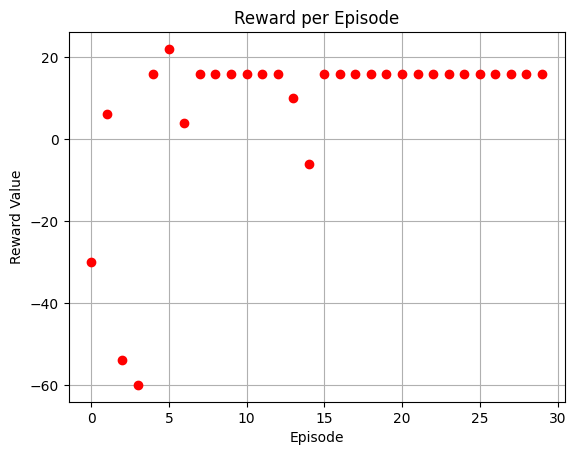

In [29]:
rewards_vs_episode = reward_plot(q_learning_output_12[1])
rewards_vs_episode.show()

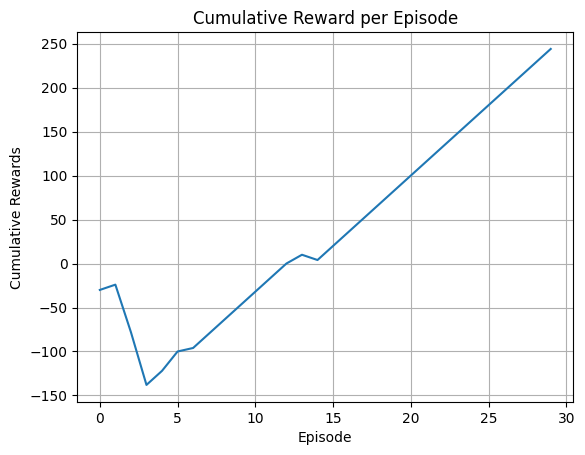

In [30]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output_12[1])
cumulative_rewards_vs_episode.show()

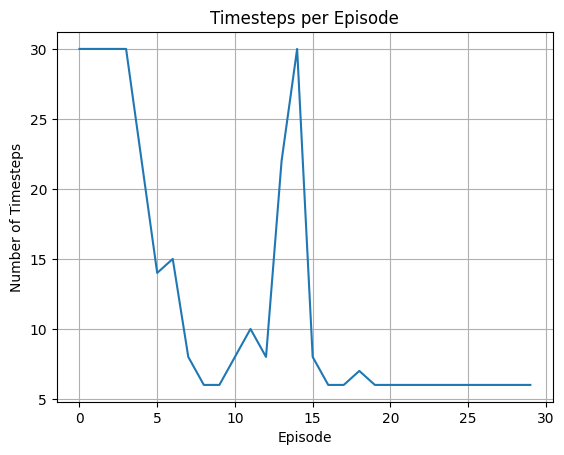

In [31]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output_12[2])
timesteps_vs_episode.show()

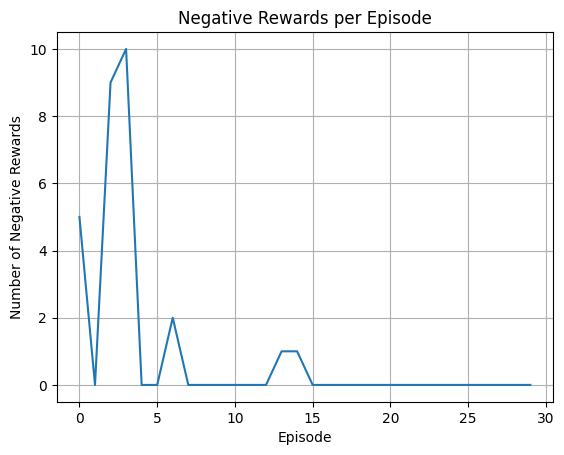

In [32]:
negative_rewards = negative_rewards_episode_plot(q_learning_output_12[3])
negative_rewards.show()

#### Parameter 1, Setup 3: Learning Rate - 0.15

In [33]:
total_episodes = 30
timesteps_per_episode = 30
learning_rate = 0.15
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_13 = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

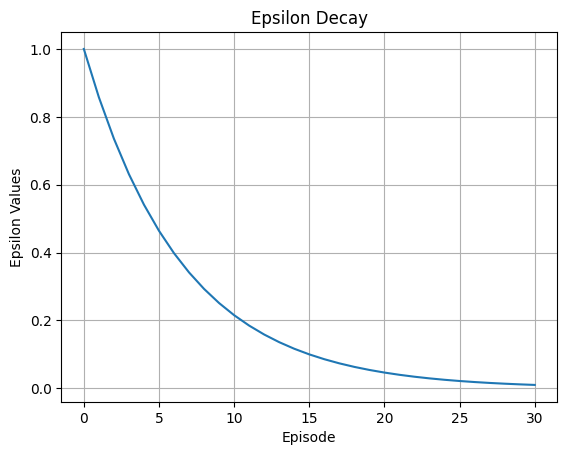

In [34]:
epsilon_decay = epsilon_decay_plot(q_learning_output_13[4])
epsilon_decay.show()

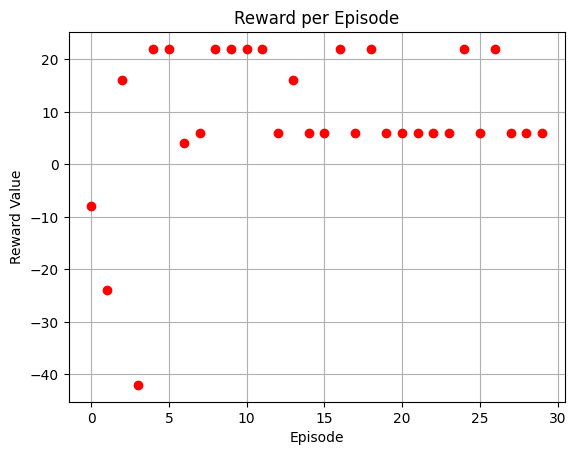

In [35]:
rewards_vs_episode = reward_plot(q_learning_output_13[1])
rewards_vs_episode.show()

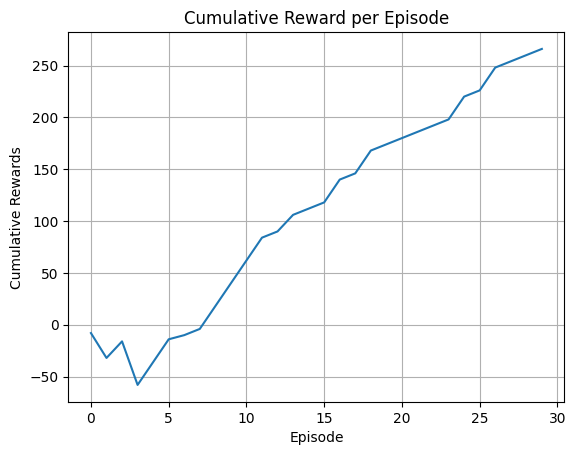

In [36]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output_13[1])
cumulative_rewards_vs_episode.show()

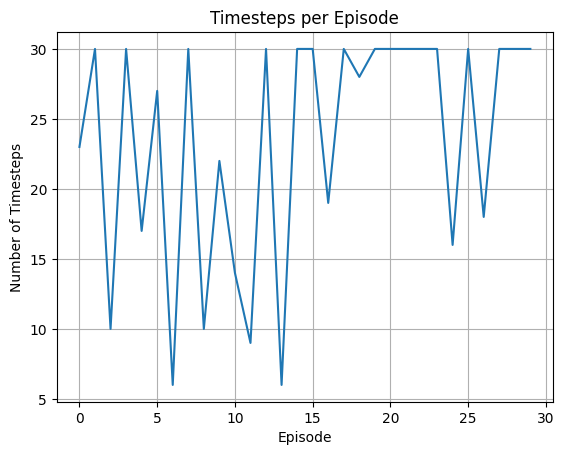

In [37]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output_13[2])
timesteps_vs_episode.show()

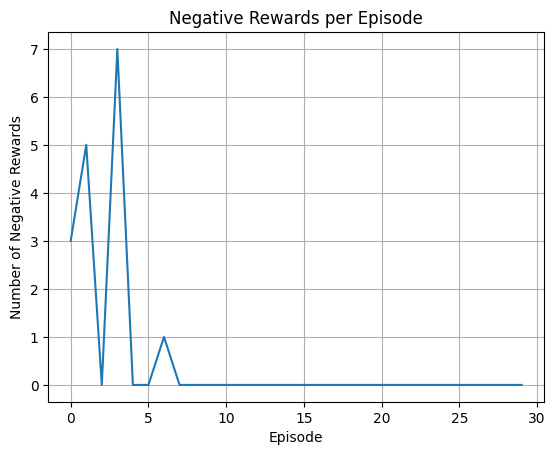

In [38]:
negative_rewards = negative_rewards_episode_plot(q_learning_output_13[3])
negative_rewards.show()

### Parameter 2: Discount Factor

#### Parameter 2, Setup 1: Discount Factor - 0.9

In [39]:
total_episodes = 50
timesteps_per_episode = 50
learning_rate = 0.15
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_21 = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

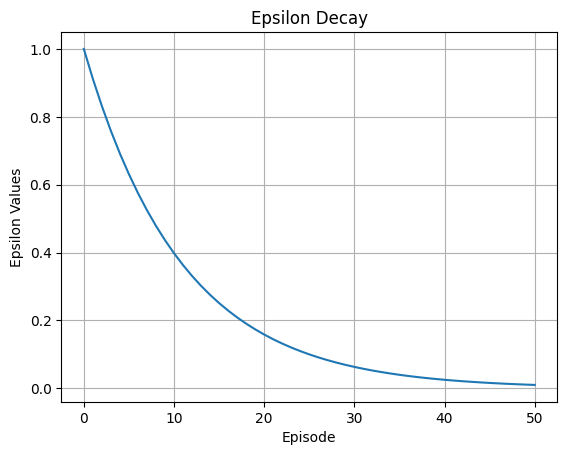

In [40]:
epsilon_decay = epsilon_decay_plot(q_learning_output_21[4])
epsilon_decay.show()

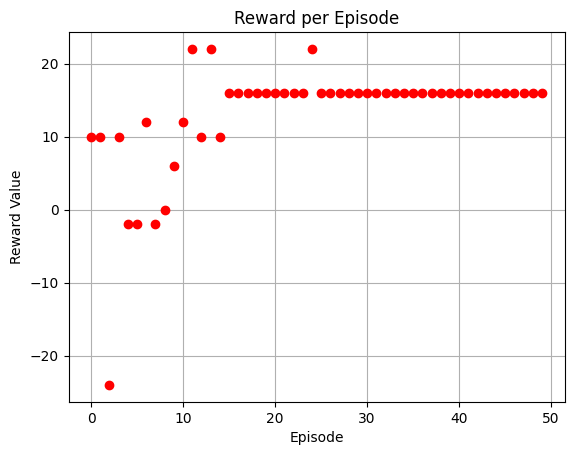

In [41]:
rewards_vs_episode = reward_plot(q_learning_output_21[1])
rewards_vs_episode.show()

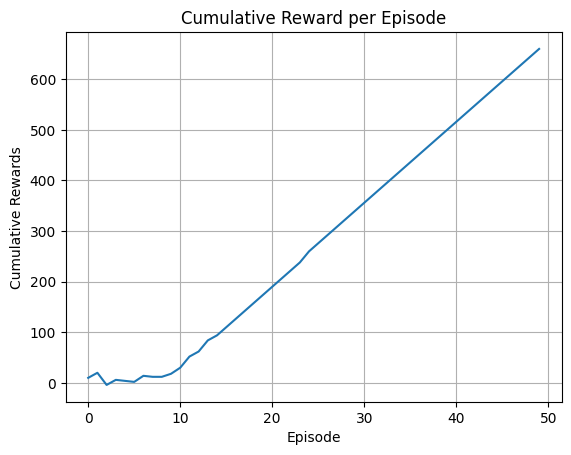

In [42]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output_21[1])
cumulative_rewards_vs_episode.show()

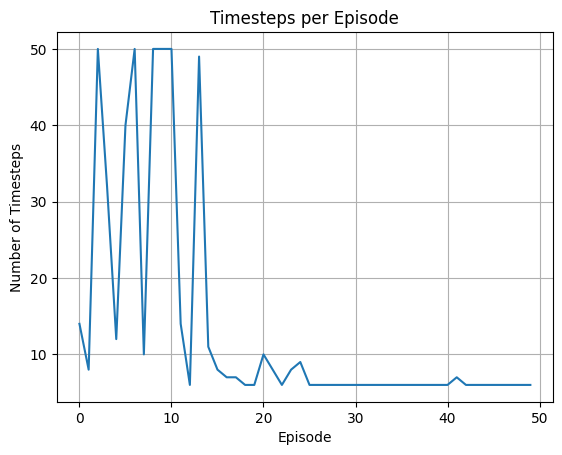

In [43]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output_21[2])
timesteps_vs_episode.show()

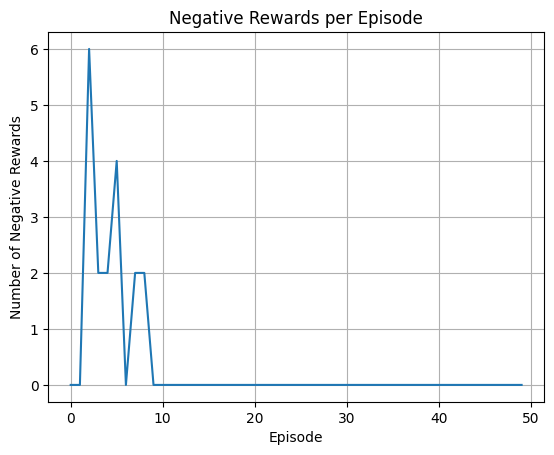

In [44]:
negative_rewards = negative_rewards_episode_plot(q_learning_output_21[3])
negative_rewards.show()

#### Parameter 2, Setup 2: Discount Factor - 0.99

In [45]:
total_episodes = 50
timesteps_per_episode = 50
learning_rate = 0.15
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.99
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_22 = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

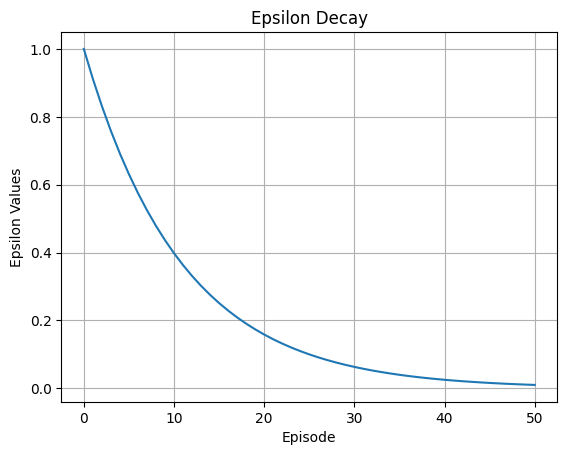

In [46]:
epsilon_decay = epsilon_decay_plot(q_learning_output_22[4])
epsilon_decay.show()

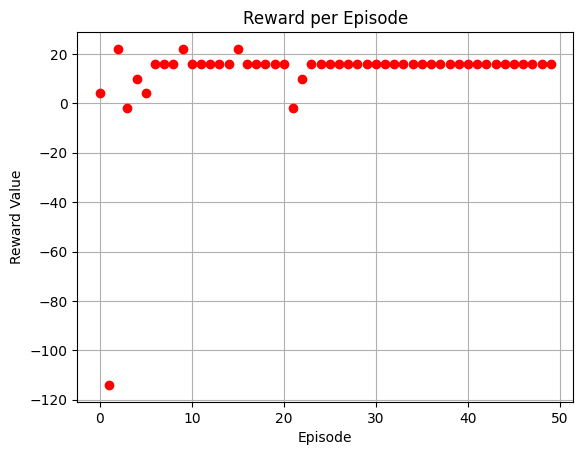

In [47]:
rewards_vs_episode = reward_plot(q_learning_output_22[1])
rewards_vs_episode.show()

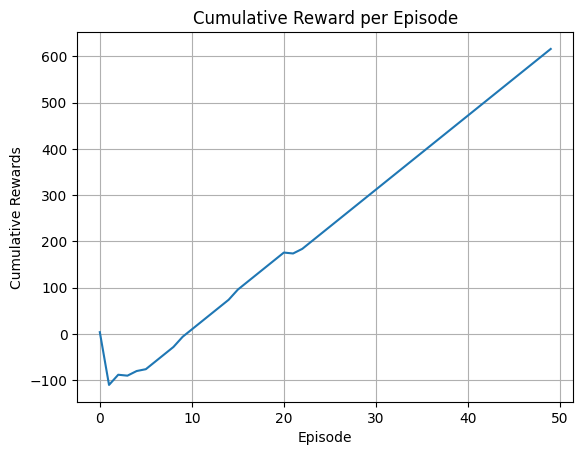

In [48]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output_22[1])
cumulative_rewards_vs_episode.show()

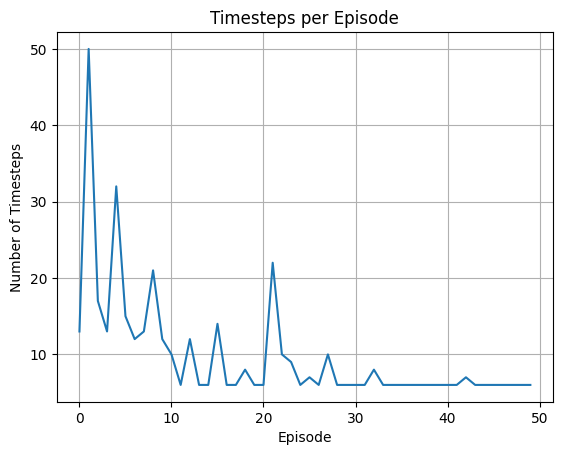

In [49]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output_22[2])
timesteps_vs_episode.show()

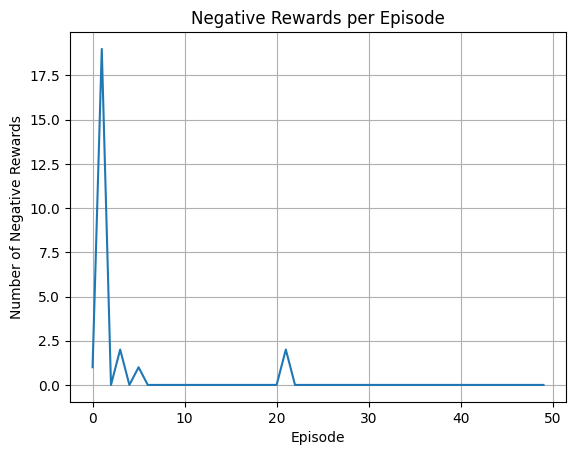

In [50]:
negative_rewards = negative_rewards_episode_plot(q_learning_output_22[3])
negative_rewards.show()

#### Parameter 2, Setup 3: Discount Factor - 0.95

In [51]:
total_episodes = 30
timesteps_per_episode = 30
learning_rate = 0.15
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.955
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_23 = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

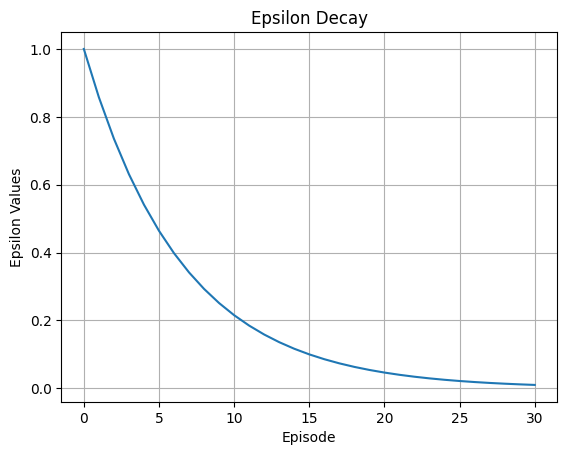

In [52]:
epsilon_decay = epsilon_decay_plot(q_learning_output_23[4])
epsilon_decay.show()

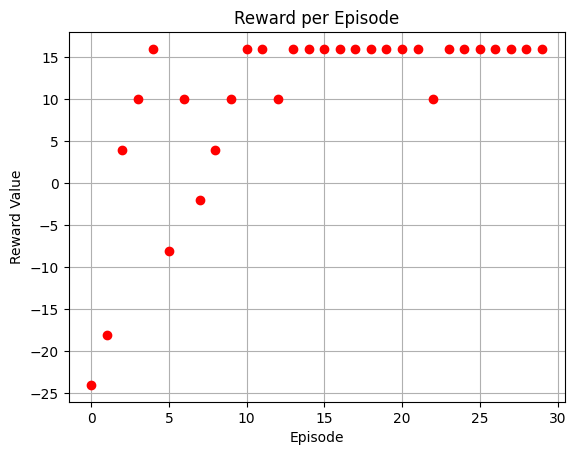

In [53]:
rewards_vs_episode = reward_plot(q_learning_output_23[1])
rewards_vs_episode.show()

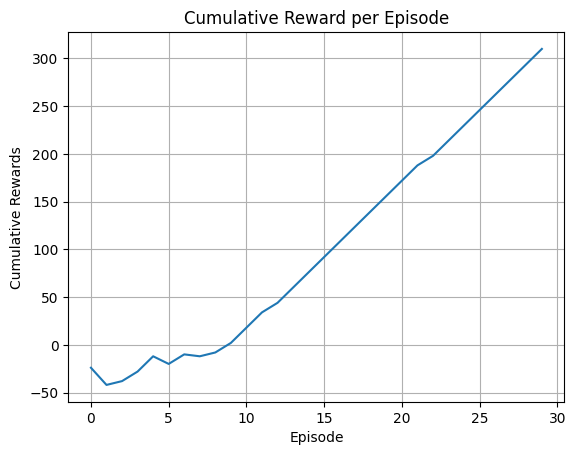

In [54]:
cumulative_rewards_vs_episode = cumulative_reward_plot(q_learning_output_23[1])
cumulative_rewards_vs_episode.show()

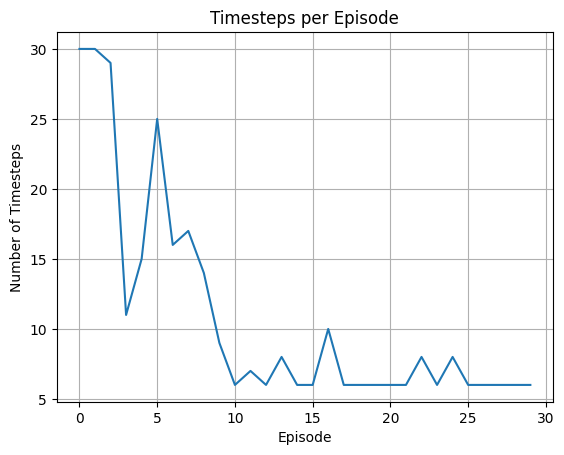

In [55]:
timesteps_vs_episode = timestep_episode_plot(q_learning_output_23[2])
timesteps_vs_episode.show()

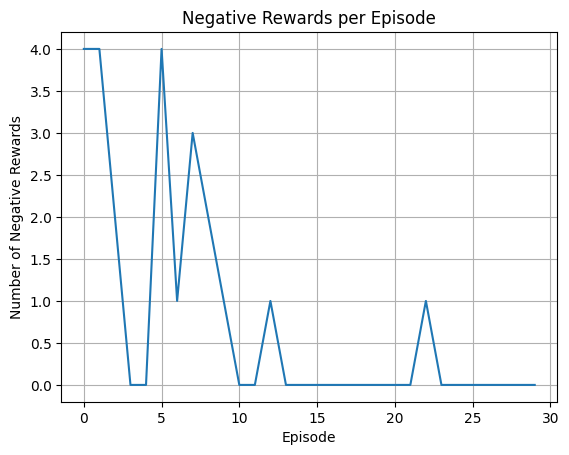

In [56]:
negative_rewards = negative_rewards_episode_plot(q_learning_output_23[3])
negative_rewards.show()

## Using Optuna to Get Best Hyper Parameters

In [57]:
def objective(trial):
  total_episodes = trial.suggest_int(name="total_episodes", low=20, high=1000)
  timesteps_per_episode = trial.suggest_int(name="timesteps_per_episode", low=25, high=100)
  learning_rate = trial.suggest_float(name="learning_rate", low=0.1, high=0.2)
  epsilon = 1
  epsilon_min = 0.01
  discount_factor = trial.suggest_float(name="discount_factor", low=0.9, high=0.99)
  decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

  env = GridEnvironment(max_timesteps=timesteps_per_episode)
  Q_table = np.zeros((env.observation_space.n, env.action_space.n))
  q_learning_output = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)
  return sum(q_learning_output[1]) / len(q_learning_output[1])

In [58]:
study = optuna.create_study(study_name="q_learning_tuning", direction="maximize")
study.optimize(objective, n_trials=300)

[I 2023-05-11 23:23:04,197] A new study created in memory with name: q_learning_tuning
[I 2023-05-11 23:23:05,756] Trial 0 finished with value: 19.31878787878788 and parameters: {'total_episodes': 825, 'timesteps_per_episode': 75, 'learning_rate': 0.15706819585251175, 'discount_factor': 0.9201449354837481}. Best is trial 0 with value: 19.31878787878788.
[I 2023-05-11 23:23:06,307] Trial 1 finished with value: 14.75 and parameters: {'total_episodes': 256, 'timesteps_per_episode': 85, 'learning_rate': 0.147597397298261, 'discount_factor': 0.9583099154640514}. Best is trial 0 with value: 19.31878787878788.
[I 2023-05-11 23:23:06,469] Trial 2 finished with value: 18.7 and parameters: {'total_episodes': 120, 'timesteps_per_episode': 99, 'learning_rate': 0.12593383231615896, 'discount_factor': 0.9253215440044316}. Best is trial 0 with value: 19.31878787878788.
[I 2023-05-11 23:23:07,352] Trial 3 finished with value: 19.54558610709117 and parameters: {'total_episodes': 691, 'timesteps_per_epi

In [59]:
study.best_params

{'total_episodes': 106,
 'timesteps_per_episode': 90,
 'learning_rate': 0.1654236359923048,
 'discount_factor': 0.9073992872379182}

## Comparing Performace of SARSA and Q-Learning

In [60]:
# Loading SARSA Algorithm

def SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, q_table):

  def action_select(epsilon, state):
    # Exploitation
    if(np.random.uniform() > epsilon):
      return np.argmax(q_table[state])

    # Exploration
    else:
      return np.random.randint(4)

  rewards = []
  timesteps = []
  bad_rewards = []
  epsilon_values = []
  epsilon_values.append(epsilon)

  for i in range(0, total_episodes):
    env.reset()
    terminated = False
    agent = RandomAgent(env)

    state_prev = 0
    action_prev = action_select(epsilon, 0)

    state_count = 0
    bad_reward_count = 0
    while(not terminated):
      action = agent.step(action_prev)
      observation, reward, terminated, bad_reward, total_rewards = env.step(action)
      if(not bad_reward):
        bad_reward_count += 1
      state_next = int(np.where(observation == 10)[0])
      action_next = action_select(epsilon, int(np.where(observation == 10)[0]))
      q_table[state_prev][action_prev] = q_table[state_prev][action_prev] + learning_rate * (reward + (discount_factor * q_table[state_next][action_next]) - q_table[state_prev][action_prev])
      state_prev = state_next
      action_prev = action_next
      state_count += 1
      if(terminated):
        rewards.append(total_rewards)
        timesteps.append(state_count)
        bad_rewards.append(bad_reward_count)

    epsilon = epsilon * decay_rate
    epsilon_values.append(epsilon) 

  return q_table, rewards, timesteps, bad_rewards, epsilon_values

### SARSA with Best Hyper Parameters

In [61]:
total_episodes = 100
timesteps_per_episode = 100
learning_rate = 0.11283665375771099
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9706886930429248
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_comparative = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

### Q-Learning with Best Hyper Parameters

In [62]:
total_episodes = 100
timesteps_per_episode = 100
learning_rate = 0.1342406833602357
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9058378315903461
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply Q-Learning
q_learning_output_comparative = QLearning(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

In [63]:
def plot_comparative(sarsa_rewards, q_learning_rewards):
  episodes = len(sarsa_rewards)
  sarsa_cumulative = [0] * episodes
  q_learning_cumulative = [0] * episodes
  sarsa_cumulative[0] = sarsa_rewards[0]
  q_learning_cumulative[0] = q_learning_rewards[0]
  for i in range(episodes):
    if(i == 0):
      continue
    sarsa_cumulative[i] = sarsa_cumulative[i - 1] + sarsa_rewards[i]
    q_learning_cumulative[i] = q_learning_cumulative[i - 1] + q_learning_rewards[i]
  plt.plot(sarsa_cumulative)
  plt.plot(q_learning_cumulative)
  plt.title('SARSA vs. Q-Learning Cumulative Rewards')
  plt.xlabel('Episodes')
  plt.ylabel('Cumulative Rewards')
  plt.legend(['SARSA', 'Q-Learning'], loc='upper right')
  return plt

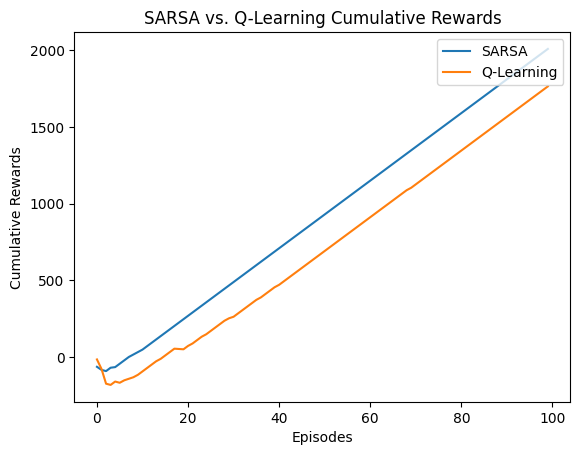

In [64]:
comparative_plot = plot_comparative(sarsa_output_comparative[1], q_learning_output_comparative[1])
comparative_plot.show()